<a href="https://colab.research.google.com/github/TheWiseGhost/Calculus_AI/blob/main/Math_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Creating a Math AI that can solve calculus problems

# Exploring a few models, older models and experiments are shown
# as you scroll to the bottom of the page

# Started 1/22/25
# Aditya Byju

#Neural Net

In [4]:
import sympy as sp
import random

# Function to generate random calculus problems
def generate_calculus_problems(num_problems=100):
    data = []
    for _ in range(num_problems):
        # Random polynomial function
        x = sp.symbols('x')
        degree = random.randint(1, 3)  # Degree of the polynomial
        coefficients = [random.randint(-10, 10) for _ in range(degree + 1)]
        poly = sum(c * x**i for i, c in enumerate(coefficients))

        # Randomly choose between differentiation or integration
        if random.choice(['diff', 'integrate']) == 'diff':
            problem = f"d/dx({poly})"
            solution = sp.diff(poly, x)
        else:
            problem = f"∫({poly})dx"
            solution = sp.integrate(poly, x)

        data.append((str(problem), str(solution) + " + C" if '∫' in problem else str(solution)))

    return data

# Generate and save dataset
problems = generate_calculus_problems(10000)


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence

# Create a vocabulary dictionary, ensuring we include the needed symbols.
vocab = defaultdict(lambda: len(vocab))

# Add special symbols to the vocabulary (such as x, operators, etc.)
for token in ['x', '+', '-', '*', '/', '(', ')', '∫', 'd/dx', 'dx']:
    vocab[token]  # Ensure these tokens are in the vocab

# Add all symbols in the dataset to the vocabulary
def update_vocab_with_data(data):
    for problem, solution in data:
        for token in problem.split():
            vocab[token]  # Add tokens from the problem to the vocab
        for token in solution.split():
            vocab[token]  # Add tokens from the solution to the vocab

# Call this function to ensure the vocab is updated
update_vocab_with_data(problems)

def tokenize_expression(expression):
    return [vocab[token] for token in expression.replace('(', ' ( ').replace(')', ' ) ').split() if token in vocab]


class CalculusDataset(Dataset):
    def __init__(self, data, vocab, max_length=50):
        self.data = data
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        problem, solution = self.data[idx]
        # Tokenize the problem and solution
        input_ids = torch.tensor(tokenize_expression(problem))
        target_ids = torch.tensor(tokenize_expression(solution))

        # Padding the sequences to the maximum length
        input_ids = torch.cat([input_ids, torch.zeros(self.max_length - len(input_ids))], dim=0)[:self.max_length]
        target_ids = torch.cat([target_ids, torch.zeros(self.max_length - len(target_ids))], dim=0)[:self.max_length]

        return input_ids.long(), target_ids.long()

    def collate_fn(batch):
        input_batch = [item[0] for item in batch]
        target_batch = [item[1] for item in batch]
        input_batch = pad_sequence(input_batch, batch_first=True, padding_value=0)  # Padding input
        target_batch = pad_sequence(target_batch, batch_first=True, padding_value=0)  # Padding target
        return input_batch, target_batch


# Prepare dataset
dataset = CalculusDataset(problems, vocab)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=CalculusDataset.collate_fn)

In [17]:
import torch.nn as nn
import torch.optim as optim

class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2SeqModel, self).__init__()
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.encoder(x)
        rnn_out, (hidden, cell) = self.rnn(embedded)
        output = self.decoder(rnn_out)
        return output

# Initialize model, loss function, and optimizer
input_size = len(vocab)  # Number of tokens in vocabulary
hidden_size = 256        # Number of hidden units in the RNN
output_size = len(vocab) # Output size is the same as the input size (for token prediction)

model = Seq2SeqModel(input_size, hidden_size, output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for input_ids, target_ids in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model(input_ids)

        # Compute the loss
        output = output.view(-1, output_size)
        target_ids = target_ids.view(-1)
        loss = loss_fn(output, target_ids)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}")


Epoch [1/5], Loss: 0.2422828232884407
Epoch [2/5], Loss: 0.18427832058668137
Epoch [3/5], Loss: 0.18252447969317437
Epoch [4/5], Loss: 0.1818704092502594
Epoch [5/5], Loss: 0.1811661997318268


In [19]:
def solve_problem(model, problem):
    model.eval()
    input_ids = torch.tensor(tokenize_expression(problem)).unsqueeze(0)  # Add batch dimension
    output = model(input_ids)
    predicted_ids = output.argmax(dim=-1).squeeze().tolist()  # Get the token with the highest probability

    # Decode the output tokens back to text
    reversed_vocab = {v: k for k, v in vocab.items()}
    solution = ' '.join([reversed_vocab[id] for id in predicted_ids if id != 0])  # Remove padding
    return solution

# Example test problem
test_problem = "∫(3x^2 + 2x + 1)dx"
solution = solve_problem(model, test_problem)
print(f"Problem: {test_problem}")
print(f"Solution: {solution}")


Problem: ∫(3x^2 + 2x + 1)dx
Solution: -9*x**4/4 - x**3/3 -


In [ ]:
torch.save(model.state_dict(), "calculus_solver.pth")

#Simple Reward system algo + Gym API AI model with PyTorch


In [ ]:
# Basic test
import sympy as sp
import random

def generate_calculus_problem():
    x = sp.symbols('x')
    degree = random.choice([1, 2, 3])

    # Get a random polynomial
    poly = sum(random.randint(1, 5) * x**i for i in range(degree + 1))

    # Get the derivative
    solution = sp.diff(poly, x)
    return poly, solution

# Example problem generation
problem, solution = generate_calculus_problem()
print(f"Problem: {problem}")
print(f"Solution (derivative): {solution}")

Problem: 5*x**3 + x**2 + x + 4
Solution (derivative): 15*x**2 + 2*x + 1


In [ ]:
# Create the Gym API
# Trying to use a reward algo
import gym
from gym import spaces
import numpy as np

# Environment Class
class CalculusEnv(gym.Env):
    def __init__(self, reward_system):
        super(CalculusEnv, self).__init__()

        # Actions:
        # {0: 'differentiate', 1: 'simplify', 2: 'check', 3: 'finish'}
        self.action_space = spaces.Discrete(4)

        # States:
         # {0: 'in_progress', 1: 'solved'}
        self.observation_space = spaces.Discrete(2)
        self.reward_system = reward_system
        self.reset()

    def reset(self):
        self.problem, self.solution = generate_calculus_problem()
        self.current_step = 0
        self.done = False
        self.state = 0  # 'in_progress'
        return self.state

    def step(self, action, user_step=None):
    if self.done:
        return self.state, 0, True, {}

    reward = 0
    info = {}

    if action == 0:  # Differentiate
        if self.is_correct_step(user_step):  # Validate the differentiation step
            reward = self.reward_system['correct_derivative']
            self.current_step += 1
            if self.current_step == len(str(self.solution)):
                self.done = True
        else:
            reward = self.reward_system['incorrect_step']

    elif action == 1:  # Simplify
        if self.is_correct_step(user_step):  # Validate simplification
            reward = self.reward_system['simplify']
        else:
            reward = self.reward_system['unnecessary_simplify']

    elif action == 2:  # Check Answer
        if user_step == self.solution:  # Validate final answer
            self.done = True
            reward = self.reward_system['correct_check']
            info = {'info': 'Correct answer'}
        else:
            reward = self.reward_system['incorrect_check']

    elif action == 3:  # Finish
        if self.current_step == len(str(self.solution)):
            self.done = True
            reward = self.reward_system['finish_correct']
            info = {'info': 'Solved'}
        else:
            reward = self.reward_system['finish_incorrect']
    else:
        reward = self.reward_system['invalid_action']

    return self.state, reward, self.done, info

    def render(self):
        return f"Current Problem: {self.problem}, Steps Taken: {self.current_step}"

In [ ]:
# Q-Learning Algo to train the AI
import torch
import torch.nn as nn
import torch.optim as optim

class QLearningAgent(nn.Module):
    def __init__(self, state_size, action_size):
        super(QLearningAgent, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def forward(self, state):
        return self.fc(state)

# Initialize the Q-learning agent
state_size = 1  # Only one state (in_progress or solved)
action_size = 4  # Four actions
agent = QLearningAgent(state_size, action_size)

# Initialize the target Q-value (to store the best action)
target_q_value = QLearningAgent(state_size, action_size)
target_q_value.load_state_dict(agent.state_dict())


<All keys matched successfully>

In [ ]:
# Test the AI
import random
from collections import deque

def train_agent(hyperparameters, reward_system):
    state_size = 1
    action_size = 4
    agent = QLearningAgent(state_size, action_size)
    target_q_value = QLearningAgent(state_size, action_size)
    target_q_value.load_state_dict(agent.state_dict())

    env = CalculusEnv(reward_system)

    episodes = hyperparameters['episodes']
    gamma = hyperparameters['gamma']
    epsilon = hyperparameters['epsilon']
    epsilon_decay = hyperparameters['epsilon_decay']
    min_epsilon = hyperparameters['min_epsilon']
    batch_size = hyperparameters['batch_size']

    memory = deque(maxlen=10000)
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        state_tensor = torch.tensor([state], dtype=torch.float32)
        total_reward = 0

        while not env.done:
            if random.random() < epsilon:
                action = random.choice(range(action_size))
            else:
                with torch.no_grad():
                    action_values = agent(state_tensor)
                    action = torch.argmax(action_values).item()

            next_state, reward, done, _ = env.step(action)
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            memory.append((state_tensor, action, reward, next_state_tensor, done))

            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                for s, a, r, ns, d in batch:
                    q_value = agent(s)[a]
                    target_value = r + (gamma * torch.max(target_q_value(ns)) * (1 - d))
                    loss = nn.MSELoss()(q_value, target_value)

                    agent.optimizer.zero_grad()
                    loss.backward()
                    agent.optimizer.step()

            state_tensor = next_state_tensor
            total_reward += reward

        if epsilon > min_epsilon:
            epsilon *= epsilon_decay

        total_rewards.append(total_reward)
        target_q_value.load_state_dict(agent.state_dict())

    return agent, np.mean(total_rewards[-10:])  # Return the average reward of the last 10 episodes

In [ ]:
# Find the best model and params
hyperparameter_sets = [
    {'episodes': 100, 'gamma': 0.99, 'epsilon': 1.0, 'epsilon_decay': 0.995, 'min_epsilon': 0.1, 'batch_size': 16},
    {'episodes': 100, 'gamma': 0.9, 'epsilon': 1.0, 'epsilon_decay': 0.99, 'min_epsilon': 0.05, 'batch_size': 32},
]

reward_systems = [
    {'correct_derivative': 10, 'step_penalty': -0.5, 'simplify': 2, 'unnecessary_simplify': -1, 'correct_check': 10, 'incorrect_check': -5, 'finish_correct': 10, 'finish_incorrect': -10, 'invalid_action': -10},
    {'correct_derivative': 15, 'step_penalty': -1, 'simplify': 1, 'unnecessary_simplify': -2, 'correct_check': 15, 'incorrect_check': -10, 'finish_correct': 15, 'finish_incorrect': -15, 'invalid_action': -15},
]

best_performance = -float('inf')

for hyperparams in hyperparameter_sets:
    for rewards in reward_systems:
        avg_reward = train_agent(hyperparams, rewards)
        print(f"Hyperparams: {hyperparams}, Rewards: {rewards}, Avg Reward: {avg_reward}")

        if avg_reward > best_performance:
            best_performance = avg_reward
            best_hyperparams = hyperparams
            best_reward_system = rewards

print("\nBest Hyperparameters:", best_hyperparams)
print("Best Reward System:", best_reward_system)


Hyperparams: {'episodes': 100, 'gamma': 0.99, 'epsilon': 1.0, 'epsilon_decay': 0.995, 'min_epsilon': 0.1, 'batch_size': 16}, Rewards: {'correct_derivative': 10, 'step_penalty': -0.5, 'simplify': 2, 'unnecessary_simplify': -1, 'correct_check': 10, 'incorrect_check': -5, 'finish_correct': 10, 'finish_incorrect': -10, 'invalid_action': -10}, Avg Reward: -38.3
Hyperparams: {'episodes': 100, 'gamma': 0.99, 'epsilon': 1.0, 'epsilon_decay': 0.995, 'min_epsilon': 0.1, 'batch_size': 16}, Rewards: {'correct_derivative': 15, 'step_penalty': -1, 'simplify': 1, 'unnecessary_simplify': -2, 'correct_check': 15, 'incorrect_check': -10, 'finish_correct': 15, 'finish_incorrect': -15, 'invalid_action': -15}, Avg Reward: -221.5
Hyperparams: {'episodes': 100, 'gamma': 0.9, 'epsilon': 1.0, 'epsilon_decay': 0.99, 'min_epsilon': 0.05, 'batch_size': 32}, Rewards: {'correct_derivative': 10, 'step_penalty': -0.5, 'simplify': 2, 'unnecessary_simplify': -1, 'correct_check': 10, 'incorrect_check': -5, 'finish_corre

In [ ]:
# Best model
hyperparameters = {'episodes': 100, 'gamma': 0.9, 'epsilon': 1.0, 'epsilon_decay': 0.99, 'min_epsilon': 0.05, 'batch_size': 32}
rewards = {'correct_derivative': 10, 'step_penalty': -0.5, 'simplify': 2, 'unnecessary_simplify': -1, 'correct_check': 10, 'incorrect_check': -5, 'finish_correct': 10, 'finish_incorrect': -10, 'invalid_action': -10}
trained_agent, rewards = train_agent(hyperparameters, rewards)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Basic function to test the AI
def test_agent(agent, rewards, episodes=10):
    env = CalculusEnv(rewards)
    for episode in range(episodes):
        state = env.reset()
        state_tensor = torch.tensor([state], dtype=torch.float32)
        total_reward = 0

        while not env.done:
            with torch.no_grad():
                q_values = agent(state_tensor)
                action = torch.argmax(q_values).item()

            state, reward, done, info = env.step(action)
            state_tensor = torch.tensor([state], dtype=torch.float32)
            total_reward += reward

        print(f"Test Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

In [ ]:
rewards = {'correct_derivative': 10, 'step_penalty': -0.5, 'simplify': 2, 'unnecessary_simplify': -1, 'correct_check': 10, 'incorrect_check': -5, 'finish_correct': 10, 'finish_incorrect': -10, 'invalid_action': -10}
test_agent(trained_agent, rewards)

KeyboardInterrupt: 

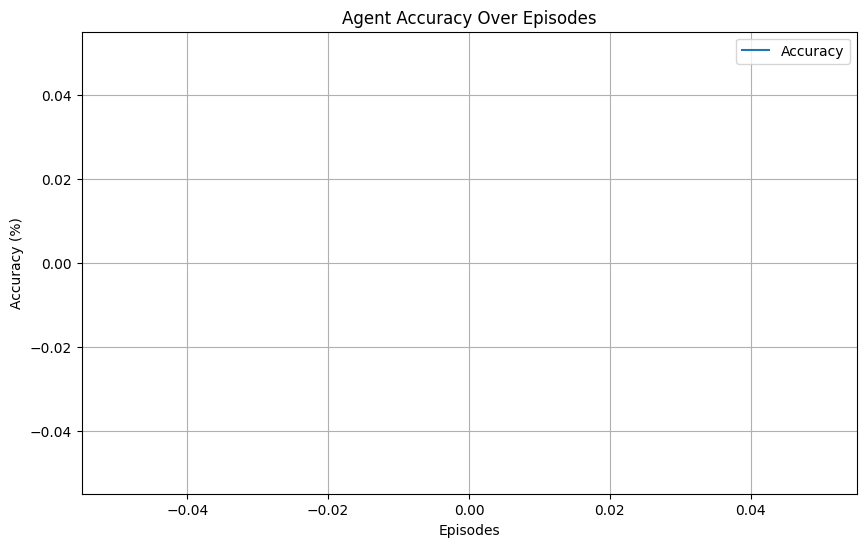

In [ ]:
# Visualize the AI to evaluate and understand what happened
import matplotlib.pyplot as plt

# Visualize accuracy over episodes
def plot_accuracy_progress(accuracy_list):
    plt.figure(figsize=(10, 6))
    plt.plot(accuracy_list, label='Accuracy')
    plt.xlabel('Episodes')
    plt.ylabel('Accuracy (%)')
    plt.title('Agent Accuracy Over Episodes')
    plt.legend()
    plt.grid()
    plt.show()

# accuracy_progress from earlier during training
plot_accuracy_progress(accuracy_progress)

In [ ]:
# Understand what the AI is messing up
def visualize_results(results, num_examples=5):
    print("Examples of Correct Solutions:")
    correct_examples = [res for res in results if res[2] == "Correct"]
    for i, (problem, solution, status) in enumerate(correct_examples[:num_examples]):
        print(f"{i + 1}. Problem: {problem}, Solution: {solution}, Status: {status}")

    print("\nExamples of Incorrect Solutions:")
    incorrect_examples = [res for res in results if res[2] == "Incorrect"]
    for i, (problem, solution, status) in enumerate(incorrect_examples[:num_examples]):
        print(f"{i + 1}. Problem: {problem}, Solution: {solution}, Status: {status}")


visualize_results(test_results)

In [ ]:
# Make a Confusion Matrix just to see if we learn anything new
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(results):
    y_true = ["Correct" if res[2] == "Correct" else "Incorrect" for res in results]
    y_pred = ["Correct" if res[2] == "Correct" else "Incorrect" for res in results]

    labels = ["Correct", "Incorrect"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(test_results)